# Pipeline Template

In [1]:
%load_ext autoreload 
%autoreload 1

In [41]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler, MatrixFactorization

%aimport util.data

### Reading Dataset

In [39]:
train_data, test_data = util.data.load()

Training Data: 
  Amount of features: 888
  Amount of observations: 1212
  Min age: 42.0 Max age: 96.0

Test Data: 
  Amount of observations: 776


# Preprocessing

## Fill Missing Values (Remove NaNs)

use one of the methods to fill the missing values

In [4]:
X_incomplete = train_data.drop(["id", "y"], axis=1).values
y = train_data["y"].values

#### k-nearest neighbors

In [6]:
k = 12

# Use nearest rows which have a feature to fill in each row's missing features
X = KNN(k=k).fit_transform(X_incomplete)

Imputing row 1/1212 with 66 missing, elapsed time: 10.716
Imputing row 101/1212 with 60 missing, elapsed time: 10.810
Imputing row 201/1212 with 68 missing, elapsed time: 10.888
Imputing row 301/1212 with 68 missing, elapsed time: 10.982
Imputing row 401/1212 with 63 missing, elapsed time: 11.076
Imputing row 501/1212 with 66 missing, elapsed time: 11.169
Imputing row 601/1212 with 77 missing, elapsed time: 11.279
Imputing row 701/1212 with 65 missing, elapsed time: 11.357
Imputing row 801/1212 with 61 missing, elapsed time: 11.435
Imputing row 901/1212 with 73 missing, elapsed time: 11.544
Imputing row 1001/1212 with 58 missing, elapsed time: 11.638
Imputing row 1101/1212 with 73 missing, elapsed time: 11.716
Imputing row 1201/1212 with 53 missing, elapsed time: 11.825


#### singular values thresholding

In [ ]:
# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X = SoftImpute().fit_transform(X_incomplete_normalized)

#### use matrix factorization

In [ ]:
X = MatrixFactorization(learning_rate= 0.001, rank=40).fit_transform(X_incomplete)

#### mean

In [ ]:
train_mean_values = train_data.mean()
train_data_mean =  train_data.fillna(train_mean_values)
X = train_data_mean.drop(["id", "y"], axis=1).values

## Data Normalization / Standardization

use one of the methods provided to normalize the data (expects no NaNs)

[Compare the effect of different scalers on data with outliers](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

#### L1 - Normalization 

In [ ]:
X = normalize(X, axis=0, norm='l1')

#### L2 - Normalization 

In [ ]:
X = normalize(X, axis=0, norm='l2')

#### Standard Scalar
removes mean and divides by std (**sensitive to outliers** => probably not a good idea)

In [ ]:
X = StandardScaler().fit_transform(X)

#### Robust Scaler
Scale features using statistics that are robust to outliers. [scikit doc](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)



In [7]:
X = RobustScaler(quantile_range=(10, 90)).fit_transform(X)

## Outlier Detection and Removal

## Feature Selection

In [8]:
# Feature Selection with Recursive Feature Elimination with Cross Validation (RFECV)

n_rm_features_per_iteration = 4
cv_k = 3

estimator = RandomForestRegressor(n_jobs=-1, n_estimators=50)

rfecv = RFECV(estimator, step=n_rm_features_per_iteration, cv=cv_k, scoring='r2', verbose=1)
rfecv.fit(X, y)


Fitting estimator with 887 features.
Fitting estimator with 883 features.
Fitting estimator with 879 features.
Fitting estimator with 875 features.
Fitting estimator with 871 features.
Fitting estimator with 867 features.
Fitting estimator with 863 features.
Fitting estimator with 859 features.
Fitting estimator with 855 features.
Fitting estimator with 851 features.
Fitting estimator with 847 features.
Fitting estimator with 843 features.
Fitting estimator with 839 features.
Fitting estimator with 835 features.
Fitting estimator with 831 features.
Fitting estimator with 827 features.
Fitting estimator with 823 features.
Fitting estimator with 819 features.
Fitting estimator with 815 features.
Fitting estimator with 811 features.
Fitting estimator with 807 features.
Fitting estimator with 803 features.
Fitting estimator with 799 features.
Fitting estimator with 795 features.
Fitting estimator with 791 features.
Fitting estimator with 787 features.
Fitting estimator with 783 features.
F

Fitting estimator with 883 features.
Fitting estimator with 879 features.
Fitting estimator with 875 features.
Fitting estimator with 871 features.
Fitting estimator with 867 features.
Fitting estimator with 863 features.
Fitting estimator with 859 features.
Fitting estimator with 855 features.
Fitting estimator with 851 features.
Fitting estimator with 847 features.
Fitting estimator with 843 features.
Fitting estimator with 839 features.
Fitting estimator with 835 features.
Fitting estimator with 831 features.
Fitting estimator with 827 features.
Fitting estimator with 823 features.
Fitting estimator with 819 features.
Fitting estimator with 815 features.
Fitting estimator with 811 features.
Fitting estimator with 807 features.
Fitting estimator with 803 features.
Fitting estimator with 799 features.
Fitting estimator with 795 features.
Fitting estimator with 791 features.
Fitting estimator with 787 features.
Fitting estimator with 783 features.
Fitting estimator with 779 features.
F

Fitting estimator with 879 features.
Fitting estimator with 875 features.
Fitting estimator with 871 features.
Fitting estimator with 867 features.
Fitting estimator with 863 features.
Fitting estimator with 859 features.
Fitting estimator with 855 features.
Fitting estimator with 851 features.
Fitting estimator with 847 features.
Fitting estimator with 843 features.
Fitting estimator with 839 features.
Fitting estimator with 835 features.
Fitting estimator with 831 features.
Fitting estimator with 827 features.
Fitting estimator with 823 features.
Fitting estimator with 819 features.
Fitting estimator with 815 features.
Fitting estimator with 811 features.
Fitting estimator with 807 features.
Fitting estimator with 803 features.
Fitting estimator with 799 features.
Fitting estimator with 795 features.
Fitting estimator with 791 features.
Fitting estimator with 787 features.
Fitting estimator with 783 features.
Fitting estimator with 779 features.
Fitting estimator with 775 features.
F

RFECV(cv=3,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring='r2', step=4, verbose=1)

Optimal number of features : 63
Validation Score: 0.5184571953409342


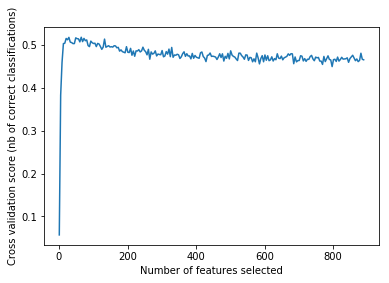

Selected Features: 
['x0' 'x42' 'x80' 'x82' 'x89' 'x94' 'x96' 'x120' 'x137' 'x178' 'x185'
 'x186' 'x192' 'x224' 'x234' 'x237' 'x264' 'x273' 'x280' 'x291' 'x300'
 'x309' 'x320' 'x328' 'x331' 'x333' 'x340' 'x349' 'x391' 'x400' 'x424'
 'x426' 'x449' 'x450' 'x470' 'x479' 'x499' 'x520' 'x529' 'x536' 'x547'
 'x555' 'x559' 'x604' 'x618' 'x644' 'x651' 'x658' 'x664' 'x673' 'x685'
 'x686' 'x687' 'x722' 'x730' 'x739' 'x743' 'x746' 'x751' 'x800' 'x810'
 'x871' 'x882']


In [36]:
print("Optimal number of features : %d" % rfecv.n_features_) #47
print(f"Validation Score: {max(rfecv.grid_scores_)}")

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, n_rm_features_per_iteration * len(rfecv.grid_scores_) + 1, n_rm_features_per_iteration), rfecv.grid_scores_)
plt.show()

selected_feature_cols = train_data.columns.values[1:-1][rfecv.support_]

print('Selected Features: ')
print(selected_feature_cols)

# Model Selection

#### K-Fold Cross Validation

In [38]:
X_sel_incomplete= train_data[selected_feature_cols].values
X_sel =  KNN(k=k).fit_transform(X_sel_incomplete)
X_sel = RobustScaler(quantile_range=(10, 90)).fit_transform(X_sel)

y_sel = train_data["y"].values


#pca = PCA(n_components=100, whiten=False)
#X_sel = pca.fit_transform(X)
#y_sel = y

estimator = MLPRegressor(learning_rate='constant', 
                        hidden_layer_sizes=(60, 40),
                         activation='logistic', 
                         learning_rate_init=0.0001, 
                         max_iter=15000, 
                         early_stopping =True,
                         validation_fraction=0.1,
                         tol=0.000000001,
                        alpha=0.8,
                         #n_iter_no_change=10,
                         verbose=True)

estimator.fit(X_sel,y_sel)
estimator.score(X_sel,y_sel)

#score = cross_val_score((estimator), X_sel, y_sel, scoring='r2', cv=4)
#print(score.mean())


Imputing row 1/1212 with 4 missing, elapsed time: 0.859
Imputing row 101/1212 with 6 missing, elapsed time: 0.875
Imputing row 201/1212 with 8 missing, elapsed time: 0.875
Imputing row 301/1212 with 5 missing, elapsed time: 0.875
Imputing row 401/1212 with 3 missing, elapsed time: 0.890
Imputing row 501/1212 with 2 missing, elapsed time: 0.890
Imputing row 601/1212 with 4 missing, elapsed time: 0.906
Imputing row 701/1212 with 5 missing, elapsed time: 0.906
Imputing row 801/1212 with 2 missing, elapsed time: 0.906
Imputing row 901/1212 with 2 missing, elapsed time: 0.922
Imputing row 1001/1212 with 5 missing, elapsed time: 0.922
Imputing row 1101/1212 with 3 missing, elapsed time: 0.937
Imputing row 1201/1212 with 5 missing, elapsed time: 0.937
Iteration 1, loss = 2544.80719867
Validation score: -49.019070
Iteration 2, loss = 2542.33425286
Validation score: -48.970829
Iteration 3, loss = 2539.85603463
Validation score: -48.922707
Iteration 4, loss = 2537.38738331
Validation score: -48.

Validation score: -43.804413
Iteration 149, loss = 2274.18992558
Validation score: -43.778238
Iteration 150, loss = 2272.86165931
Validation score: -43.752134
Iteration 151, loss = 2271.53380687
Validation score: -43.726106
Iteration 152, loss = 2270.21558293
Validation score: -43.700166
Iteration 153, loss = 2268.89753187
Validation score: -43.674327
Iteration 154, loss = 2267.58384465
Validation score: -43.648536
Iteration 155, loss = 2266.27836156
Validation score: -43.622840
Iteration 156, loss = 2264.97603953
Validation score: -43.597244
Iteration 157, loss = 2263.67300997
Validation score: -43.571753
Iteration 158, loss = 2262.38050349
Validation score: -43.546237
Iteration 159, loss = 2261.08436101
Validation score: -43.520858
Iteration 160, loss = 2259.79657980
Validation score: -43.495521
Iteration 161, loss = 2258.51241685
Validation score: -43.470219
Iteration 162, loss = 2257.23354686
Validation score: -43.445044
Iteration 163, loss = 2255.95740141
Validation score: -43.419

Iteration 305, loss = 2096.72244776
Validation score: -40.289908
Iteration 306, loss = 2095.68495429
Validation score: -40.269463
Iteration 307, loss = 2094.64144561
Validation score: -40.249010
Iteration 308, loss = 2093.59794618
Validation score: -40.228525
Iteration 309, loss = 2092.55223777
Validation score: -40.207985
Iteration 310, loss = 2091.50320941
Validation score: -40.187399
Iteration 311, loss = 2090.45455067
Validation score: -40.166737
Iteration 312, loss = 2089.40061190
Validation score: -40.146036
Iteration 313, loss = 2088.34611580
Validation score: -40.125287
Iteration 314, loss = 2087.28457724
Validation score: -40.104535
Iteration 315, loss = 2086.22561097
Validation score: -40.083713
Iteration 316, loss = 2085.16221424
Validation score: -40.062827
Iteration 317, loss = 2084.09663943
Validation score: -40.041852
Iteration 318, loss = 2083.02432924
Validation score: -40.020865
Iteration 319, loss = 2081.95216113
Validation score: -39.999759
Iteration 320, loss = 208

Iteration 439, loss = 1952.42234373
Validation score: -37.465189
Iteration 440, loss = 1951.41837461
Validation score: -37.445549
Iteration 441, loss = 1950.41611313
Validation score: -37.425932
Iteration 442, loss = 1949.41442172
Validation score: -37.406354
Iteration 443, loss = 1948.41602673
Validation score: -37.386772
Iteration 444, loss = 1947.41801701
Validation score: -37.367215
Iteration 445, loss = 1946.41670194
Validation score: -37.347708
Iteration 446, loss = 1945.42425078
Validation score: -37.328170
Iteration 447, loss = 1944.42624402
Validation score: -37.308716
Iteration 448, loss = 1943.43081836
Validation score: -37.289289
Iteration 449, loss = 1942.43936133
Validation score: -37.269863
Iteration 450, loss = 1941.44728172
Validation score: -37.250447
Iteration 451, loss = 1940.45547299
Validation score: -37.231027
Iteration 452, loss = 1939.46456935
Validation score: -37.211646
Iteration 453, loss = 1938.47592416
Validation score: -37.192284
Iteration 454, loss = 193

Iteration 566, loss = 1823.14975806
Validation score: -34.935885
Iteration 567, loss = 1822.16032937
Validation score: -34.916502
Iteration 568, loss = 1821.17028617
Validation score: -34.897148
Iteration 569, loss = 1820.18297383
Validation score: -34.877821
Iteration 570, loss = 1819.19899433
Validation score: -34.858523
Iteration 571, loss = 1818.21018384
Validation score: -34.839315
Iteration 572, loss = 1817.22980080
Validation score: -34.820094
Iteration 573, loss = 1816.24829990
Validation score: -34.800893
Iteration 574, loss = 1815.26828770
Validation score: -34.781719
Iteration 575, loss = 1814.28708539
Validation score: -34.762597
Iteration 576, loss = 1813.31032034
Validation score: -34.743481
Iteration 577, loss = 1812.33563815
Validation score: -34.724362
Iteration 578, loss = 1811.35801924
Validation score: -34.705304
Iteration 579, loss = 1810.38602298
Validation score: -34.686256
Iteration 580, loss = 1809.41364593
Validation score: -34.667248
Iteration 581, loss = 180

Iteration 722, loss = 1678.93681833
Validation score: -32.114299
Iteration 723, loss = 1678.04286329
Validation score: -32.096829
Iteration 724, loss = 1677.15165685
Validation score: -32.079329
Iteration 725, loss = 1676.25649156
Validation score: -32.061825
Iteration 726, loss = 1675.36374833
Validation score: -32.044305
Iteration 727, loss = 1674.46732887
Validation score: -32.026775
Iteration 728, loss = 1673.57380634
Validation score: -32.009211
Iteration 729, loss = 1672.67495708
Validation score: -31.991652
Iteration 730, loss = 1671.77758334
Validation score: -31.974057
Iteration 731, loss = 1670.87788859
Validation score: -31.956441
Iteration 732, loss = 1669.97840995
Validation score: -31.938796
Iteration 733, loss = 1669.07578379
Validation score: -31.921119
Iteration 734, loss = 1668.17176232
Validation score: -31.903416
Iteration 735, loss = 1667.26727200
Validation score: -31.885652
Iteration 736, loss = 1666.35727173
Validation score: -31.867854
Iteration 737, loss = 166

Iteration 850, loss = 1545.88064695
Validation score: -29.511174
Iteration 851, loss = 1544.92068191
Validation score: -29.492424
Iteration 852, loss = 1543.96555587
Validation score: -29.473668
Iteration 853, loss = 1543.00551104
Validation score: -29.454958
Iteration 854, loss = 1542.05316598
Validation score: -29.436248
Iteration 855, loss = 1541.09889741
Validation score: -29.417577
Iteration 856, loss = 1540.14392640
Validation score: -29.398953
Iteration 857, loss = 1539.19617387
Validation score: -29.380327
Iteration 858, loss = 1538.24534437
Validation score: -29.361734
Iteration 859, loss = 1537.29560563
Validation score: -29.343163
Iteration 860, loss = 1536.34953947
Validation score: -29.324588
Iteration 861, loss = 1535.40161661
Validation score: -29.306043
Iteration 862, loss = 1534.45646076
Validation score: -29.287522
Iteration 863, loss = 1533.50990838
Validation score: -29.269035
Iteration 864, loss = 1532.56630746
Validation score: -29.250547
Iteration 865, loss = 153

Iteration 1008, loss = 1391.41228256
Validation score: -26.487303
Iteration 1009, loss = 1390.48829973
Validation score: -26.469155
Iteration 1010, loss = 1389.56093860
Validation score: -26.450959
Iteration 1011, loss = 1388.63155803
Validation score: -26.432692
Iteration 1012, loss = 1387.69660384
Validation score: -26.414357
Iteration 1013, loss = 1386.76086209
Validation score: -26.395894
Iteration 1014, loss = 1385.81590806
Validation score: -26.377367
Iteration 1015, loss = 1384.86896074
Validation score: -26.358670
Iteration 1016, loss = 1383.91103294
Validation score: -26.339852
Iteration 1017, loss = 1382.94850923
Validation score: -26.320865
Iteration 1018, loss = 1381.97858484
Validation score: -26.301710
Iteration 1019, loss = 1380.99610495
Validation score: -26.282414
Iteration 1020, loss = 1380.00653051
Validation score: -26.262914
Iteration 1021, loss = 1379.00560965
Validation score: -26.243190
Iteration 1022, loss = 1377.99511534
Validation score: -26.223194
Iteration 

Iteration 1160, loss = 1242.86010313
Validation score: -23.576880
Iteration 1161, loss = 1241.76525544
Validation score: -23.555619
Iteration 1162, loss = 1240.67993587
Validation score: -23.534413
Iteration 1163, loss = 1239.59632904
Validation score: -23.513332
Iteration 1164, loss = 1238.52076994
Validation score: -23.492348
Iteration 1165, loss = 1237.44867386
Validation score: -23.471532
Iteration 1166, loss = 1236.38737873
Validation score: -23.450803
Iteration 1167, loss = 1235.32741113
Validation score: -23.430215
Iteration 1168, loss = 1234.27862456
Validation score: -23.409737
Iteration 1169, loss = 1233.23263511
Validation score: -23.389375
Iteration 1170, loss = 1232.19683336
Validation score: -23.369130
Iteration 1171, loss = 1231.16706538
Validation score: -23.349004
Iteration 1172, loss = 1230.13882955
Validation score: -23.329064
Iteration 1173, loss = 1229.12504927
Validation score: -23.309172
Iteration 1174, loss = 1228.10958240
Validation score: -23.289446
Iteration 

Iteration 1292, loss = 1123.01447283
Validation score: -21.230549
Iteration 1293, loss = 1122.13622955
Validation score: -21.213202
Iteration 1294, loss = 1121.24929953
Validation score: -21.195738
Iteration 1295, loss = 1120.35275284
Validation score: -21.178154
Iteration 1296, loss = 1119.45520031
Validation score: -21.160337
Iteration 1297, loss = 1118.54305166
Validation score: -21.142357
Iteration 1298, loss = 1117.62067918
Validation score: -21.124182
Iteration 1299, loss = 1116.69019069
Validation score: -21.105753
Iteration 1300, loss = 1115.74639120
Validation score: -21.087118
Iteration 1301, loss = 1114.79064481
Validation score: -21.068213
Iteration 1302, loss = 1113.81953233
Validation score: -21.049077
Iteration 1303, loss = 1112.83892658
Validation score: -21.029674
Iteration 1304, loss = 1111.84281589
Validation score: -21.010008
Iteration 1305, loss = 1110.83241540
Validation score: -20.990094
Iteration 1306, loss = 1109.80898479
Validation score: -20.969976
Iteration 

Iteration 1445, loss = 963.48814082
Validation score: -18.104291
Iteration 1446, loss = 962.61996046
Validation score: -18.087133
Iteration 1447, loss = 961.74999512
Validation score: -18.070010
Iteration 1448, loss = 960.87795226
Validation score: -18.052974
Iteration 1449, loss = 960.00883816
Validation score: -18.036003
Iteration 1450, loss = 959.14361039
Validation score: -18.019020
Iteration 1451, loss = 958.28084230
Validation score: -18.002052
Iteration 1452, loss = 957.41447748
Validation score: -17.985151
Iteration 1453, loss = 956.55354684
Validation score: -17.968240
Iteration 1454, loss = 955.69220500
Validation score: -17.951325
Iteration 1455, loss = 954.83065109
Validation score: -17.934441
Iteration 1456, loss = 953.97223430
Validation score: -17.917555
Iteration 1457, loss = 953.10963800
Validation score: -17.900729
Iteration 1458, loss = 952.25202977
Validation score: -17.883898
Iteration 1459, loss = 951.39506716
Validation score: -17.867110
Iteration 1460, loss = 95

Iteration 1600, loss = 832.94715104
Validation score: -15.541463
Iteration 1601, loss = 831.96855281
Validation score: -15.522458
Iteration 1602, loss = 831.00241196
Validation score: -15.503597
Iteration 1603, loss = 830.04437183
Validation score: -15.484901
Iteration 1604, loss = 829.09606413
Validation score: -15.466372
Iteration 1605, loss = 828.15262448
Validation score: -15.448033
Iteration 1606, loss = 827.21864110
Validation score: -15.429868
Iteration 1607, loss = 826.29488623
Validation score: -15.411782
Iteration 1608, loss = 825.37463043
Validation score: -15.393856
Iteration 1609, loss = 824.46672104
Validation score: -15.376033
Iteration 1610, loss = 823.55752522
Validation score: -15.358401
Iteration 1611, loss = 822.66496108
Validation score: -15.340859
Iteration 1612, loss = 821.77351528
Validation score: -15.323469
Iteration 1613, loss = 820.89262856
Validation score: -15.306193
Iteration 1614, loss = 820.01244688
Validation score: -15.289043
Iteration 1615, loss = 81

Iteration 1757, loss = 710.67252882
Validation score: -13.142989
Iteration 1758, loss = 709.95547856
Validation score: -13.128947
Iteration 1759, loss = 709.24160088
Validation score: -13.114899
Iteration 1760, loss = 708.52648929
Validation score: -13.100852
Iteration 1761, loss = 707.81366586
Validation score: -13.086781
Iteration 1762, loss = 707.09669162
Validation score: -13.072760
Iteration 1763, loss = 706.38398968
Validation score: -13.058727
Iteration 1764, loss = 705.66898214
Validation score: -13.044692
Iteration 1765, loss = 704.95404423
Validation score: -13.030671
Iteration 1766, loss = 704.23985353
Validation score: -13.016615
Iteration 1767, loss = 703.52422101
Validation score: -13.002507
Iteration 1768, loss = 702.80784311
Validation score: -12.988371
Iteration 1769, loss = 702.08719871
Validation score: -12.974221
Iteration 1770, loss = 701.36702081
Validation score: -12.960046
Iteration 1771, loss = 700.64466175
Validation score: -12.945860
Iteration 1772, loss = 69

Iteration 1905, loss = 571.61776924
Validation score: -10.406407
Iteration 1906, loss = 570.55349137
Validation score: -10.385370
Iteration 1907, loss = 569.49147851
Validation score: -10.364329
Iteration 1908, loss = 568.41942963
Validation score: -10.343439
Iteration 1909, loss = 567.35578699
Validation score: -10.322500
Iteration 1910, loss = 566.29135942
Validation score: -10.301501
Iteration 1911, loss = 565.22118792
Validation score: -10.280427
Iteration 1912, loss = 564.15232839
Validation score: -10.259275
Iteration 1913, loss = 563.07591525
Validation score: -10.238076
Iteration 1914, loss = 561.99862126
Validation score: -10.216795
Iteration 1915, loss = 560.91855322
Validation score: -10.195461
Iteration 1916, loss = 559.83388929
Validation score: -10.174138
Iteration 1917, loss = 558.74548046
Validation score: -10.152850
Iteration 1918, loss = 557.66152503
Validation score: -10.131569
Iteration 1919, loss = 556.58082592
Validation score: -10.110368
Iteration 1920, loss = 55

Validation score: -8.345246
Iteration 2035, loss = 466.09332860
Validation score: -8.332152
Iteration 2036, loss = 465.43231181
Validation score: -8.319056
Iteration 2037, loss = 464.76899757
Validation score: -8.306010
Iteration 2038, loss = 464.10517108
Validation score: -8.293025
Iteration 2039, loss = 463.44664328
Validation score: -8.279990
Iteration 2040, loss = 462.78708211
Validation score: -8.266979
Iteration 2041, loss = 462.12745204
Validation score: -8.253982
Iteration 2042, loss = 461.46790981
Validation score: -8.240997
Iteration 2043, loss = 460.80956874
Validation score: -8.228006
Iteration 2044, loss = 460.15361142
Validation score: -8.215030
Iteration 2045, loss = 459.49399938
Validation score: -8.202137
Iteration 2046, loss = 458.84107806
Validation score: -8.189223
Iteration 2047, loss = 458.18708125
Validation score: -8.176315
Iteration 2048, loss = 457.53105265
Validation score: -8.163480
Iteration 2049, loss = 456.88071935
Validation score: -8.150616
Iteration 20

Iteration 2191, loss = 371.87614119
Validation score: -6.474195
Iteration 2192, loss = 371.32293014
Validation score: -6.463288
Iteration 2193, loss = 370.76948141
Validation score: -6.452410
Iteration 2194, loss = 370.21945568
Validation score: -6.441538
Iteration 2195, loss = 369.66786885
Validation score: -6.430690
Iteration 2196, loss = 369.11983393
Validation score: -6.419834
Iteration 2197, loss = 368.56954486
Validation score: -6.408990
Iteration 2198, loss = 368.02033699
Validation score: -6.398149
Iteration 2199, loss = 367.47421542
Validation score: -6.387288
Iteration 2200, loss = 366.92297710
Validation score: -6.376496
Iteration 2201, loss = 366.37905474
Validation score: -6.365699
Iteration 2202, loss = 365.83467055
Validation score: -6.354935
Iteration 2203, loss = 365.28579738
Validation score: -6.344187
Iteration 2204, loss = 364.74242329
Validation score: -6.333426
Iteration 2205, loss = 364.19719577
Validation score: -6.322671
Iteration 2206, loss = 363.65353005
Vali

Iteration 2340, loss = 295.82780328
Validation score: -4.971501
Iteration 2341, loss = 295.36432465
Validation score: -4.962192
Iteration 2342, loss = 294.89508101
Validation score: -4.952907
Iteration 2343, loss = 294.42226878
Validation score: -4.943683
Iteration 2344, loss = 293.95786208
Validation score: -4.934391
Iteration 2345, loss = 293.48804419
Validation score: -4.925135
Iteration 2346, loss = 293.02134757
Validation score: -4.915861
Iteration 2347, loss = 292.55389463
Validation score: -4.906608
Iteration 2348, loss = 292.08749271
Validation score: -4.897387
Iteration 2349, loss = 291.62166094
Validation score: -4.888196
Iteration 2350, loss = 291.15996257
Validation score: -4.878990
Iteration 2351, loss = 290.69408436
Validation score: -4.869831
Iteration 2352, loss = 290.23078886
Validation score: -4.860663
Iteration 2353, loss = 289.76895110
Validation score: -4.851517
Iteration 2354, loss = 289.30814648
Validation score: -4.842363
Iteration 2355, loss = 288.84505909
Vali

Iteration 2469, loss = 239.57120111
Validation score: -3.856867
Iteration 2470, loss = 239.17290608
Validation score: -3.848871
Iteration 2471, loss = 238.76932231
Validation score: -3.840915
Iteration 2472, loss = 238.36950389
Validation score: -3.832970
Iteration 2473, loss = 237.97018266
Validation score: -3.825024
Iteration 2474, loss = 237.56749584
Validation score: -3.817104
Iteration 2475, loss = 237.16862830
Validation score: -3.809149
Iteration 2476, loss = 236.76849505
Validation score: -3.801222
Iteration 2477, loss = 236.37010940
Validation score: -3.793309
Iteration 2478, loss = 235.97175994
Validation score: -3.785402
Iteration 2479, loss = 235.57306646
Validation score: -3.777505
Iteration 2480, loss = 235.17628196
Validation score: -3.769562
Iteration 2481, loss = 234.77798872
Validation score: -3.761653
Iteration 2482, loss = 234.38306775
Validation score: -3.753777
Iteration 2483, loss = 233.98278657
Validation score: -3.745982
Iteration 2484, loss = 233.58955612
Vali

Iteration 2624, loss = 182.93537926
Validation score: -2.730888
Iteration 2625, loss = 182.60792653
Validation score: -2.724339
Iteration 2626, loss = 182.27963052
Validation score: -2.717824
Iteration 2627, loss = 181.95137207
Validation score: -2.711334
Iteration 2628, loss = 181.62757491
Validation score: -2.704792
Iteration 2629, loss = 181.29992536
Validation score: -2.698273
Iteration 2630, loss = 180.97280690
Validation score: -2.691764
Iteration 2631, loss = 180.64707128
Validation score: -2.685281
Iteration 2632, loss = 180.32205323
Validation score: -2.678824
Iteration 2633, loss = 179.99957506
Validation score: -2.672351
Iteration 2634, loss = 179.67343985
Validation score: -2.665922
Iteration 2635, loss = 179.35183671
Validation score: -2.659479
Iteration 2636, loss = 179.03019872
Validation score: -2.653027
Iteration 2637, loss = 178.70703943
Validation score: -2.646590
Iteration 2638, loss = 178.38631862
Validation score: -2.640150
Iteration 2639, loss = 178.06197174
Vali

Iteration 2753, loss = 144.53285890
Validation score: -1.963907
Iteration 2754, loss = 144.26642136
Validation score: -1.958550
Iteration 2755, loss = 144.00087698
Validation score: -1.953200
Iteration 2756, loss = 143.73070184
Validation score: -1.947886
Iteration 2757, loss = 143.46671790
Validation score: -1.942546
Iteration 2758, loss = 143.20084709
Validation score: -1.937209
Iteration 2759, loss = 142.93228087
Validation score: -1.931915
Iteration 2760, loss = 142.67063084
Validation score: -1.926572
Iteration 2761, loss = 142.40377478
Validation score: -1.921270
Iteration 2762, loss = 142.13786965
Validation score: -1.915966
Iteration 2763, loss = 141.87515103
Validation score: -1.910646
Iteration 2764, loss = 141.60980317
Validation score: -1.905347
Iteration 2765, loss = 141.34787464
Validation score: -1.900057
Iteration 2766, loss = 141.08514680
Validation score: -1.894798
Iteration 2767, loss = 140.82301549
Validation score: -1.889567
Iteration 2768, loss = 140.56090010
Vali

Iteration 2909, loss = 108.13550309
Validation score: -1.232278
Iteration 2910, loss = 107.93480976
Validation score: -1.228234
Iteration 2911, loss = 107.73502378
Validation score: -1.224194
Iteration 2912, loss = 107.53392244
Validation score: -1.220196
Iteration 2913, loss = 107.33738956
Validation score: -1.216181
Iteration 2914, loss = 107.13900186
Validation score: -1.212182
Iteration 2915, loss = 106.94053572
Validation score: -1.208207
Iteration 2916, loss = 106.74324180
Validation score: -1.204234
Iteration 2917, loss = 106.54892067
Validation score: -1.200248
Iteration 2918, loss = 106.35097139
Validation score: -1.196297
Iteration 2919, loss = 106.15546324
Validation score: -1.192335
Iteration 2920, loss = 105.96137311
Validation score: -1.188358
Iteration 2921, loss = 105.76314274
Validation score: -1.184408
Iteration 2922, loss = 105.56963660
Validation score: -1.180444
Iteration 2923, loss = 105.37474302
Validation score: -1.176516
Iteration 2924, loss = 105.17894630
Vali

Iteration 3039, loss = 85.58576932
Validation score: -0.774756
Iteration 3040, loss = 85.43590261
Validation score: -0.771753
Iteration 3041, loss = 85.28939184
Validation score: -0.768757
Iteration 3042, loss = 85.14286993
Validation score: -0.765763
Iteration 3043, loss = 84.99516340
Validation score: -0.762770
Iteration 3044, loss = 84.84957328
Validation score: -0.759746
Iteration 3045, loss = 84.70169176
Validation score: -0.756741
Iteration 3046, loss = 84.55675512
Validation score: -0.753747
Iteration 3047, loss = 84.40840720
Validation score: -0.750832
Iteration 3048, loss = 84.26705932
Validation score: -0.747895
Iteration 3049, loss = 84.12577784
Validation score: -0.744943
Iteration 3050, loss = 83.97986645
Validation score: -0.742042
Iteration 3051, loss = 83.83902047
Validation score: -0.739095
Iteration 3052, loss = 83.69368779
Validation score: -0.736180
Iteration 3053, loss = 83.55214821
Validation score: -0.733262
Iteration 3054, loss = 83.41191742
Validation score: -0

Iteration 3192, loss = 67.25340232
Validation score: -0.397460
Iteration 3193, loss = 67.15734831
Validation score: -0.395563
Iteration 3194, loss = 67.06677127
Validation score: -0.393612
Iteration 3195, loss = 66.97464503
Validation score: -0.391662
Iteration 3196, loss = 66.88133438
Validation score: -0.389755
Iteration 3197, loss = 66.78870655
Validation score: -0.387865
Iteration 3198, loss = 66.69986747
Validation score: -0.385948
Iteration 3199, loss = 66.60799713
Validation score: -0.384054
Iteration 3200, loss = 66.51965045
Validation score: -0.382157
Iteration 3201, loss = 66.42656084
Validation score: -0.380321
Iteration 3202, loss = 66.33840725
Validation score: -0.378449
Iteration 3203, loss = 66.24920433
Validation score: -0.376591
Iteration 3204, loss = 66.16131775
Validation score: -0.374739
Iteration 3205, loss = 66.07035417
Validation score: -0.372904
Iteration 3206, loss = 65.98288907
Validation score: -0.371029
Iteration 3207, loss = 65.89397264
Validation score: -0

Iteration 3353, loss = 55.99614803
Validation score: -0.161735
Iteration 3354, loss = 55.94630263
Validation score: -0.160645
Iteration 3355, loss = 55.89673479
Validation score: -0.159669
Iteration 3356, loss = 55.84614278
Validation score: -0.158679
Iteration 3357, loss = 55.79761978
Validation score: -0.157716
Iteration 3358, loss = 55.74678202
Validation score: -0.156739
Iteration 3359, loss = 55.69660536
Validation score: -0.155729
Iteration 3360, loss = 55.64736692
Validation score: -0.154697
Iteration 3361, loss = 55.59760356
Validation score: -0.153685
Iteration 3362, loss = 55.54995441
Validation score: -0.152680
Iteration 3363, loss = 55.49987263
Validation score: -0.151695
Iteration 3364, loss = 55.45091137
Validation score: -0.150835
Iteration 3365, loss = 55.39909969
Validation score: -0.149830
Iteration 3366, loss = 55.35102511
Validation score: -0.148785
Iteration 3367, loss = 55.29997052
Validation score: -0.147825
Iteration 3368, loss = 55.25045757
Validation score: -0

Iteration 3513, loss = 45.56230607
Validation score: 0.026212
Iteration 3514, loss = 45.48138224
Validation score: 0.027971
Iteration 3515, loss = 45.39671213
Validation score: 0.029566
Iteration 3516, loss = 45.31438502
Validation score: 0.031268
Iteration 3517, loss = 45.23233879
Validation score: 0.033006
Iteration 3518, loss = 45.15107919
Validation score: 0.034713
Iteration 3519, loss = 45.07023690
Validation score: 0.036591
Iteration 3520, loss = 44.98493024
Validation score: 0.038336
Iteration 3521, loss = 44.90501429
Validation score: 0.040013
Iteration 3522, loss = 44.82206644
Validation score: 0.041714
Iteration 3523, loss = 44.74181926
Validation score: 0.043379
Iteration 3524, loss = 44.65957678
Validation score: 0.045103
Iteration 3525, loss = 44.57789346
Validation score: 0.047082
Iteration 3526, loss = 44.49596679
Validation score: 0.048949
Iteration 3527, loss = 44.41258202
Validation score: 0.050651
Iteration 3528, loss = 44.33010716
Validation score: 0.052360
Iteratio

Iteration 3646, loss = 36.49016137
Validation score: 0.225058
Iteration 3647, loss = 36.43800289
Validation score: 0.226173
Iteration 3648, loss = 36.38795247
Validation score: 0.227306
Iteration 3649, loss = 36.33691538
Validation score: 0.228435
Iteration 3650, loss = 36.28611131
Validation score: 0.229569
Iteration 3651, loss = 36.23712424
Validation score: 0.230753
Iteration 3652, loss = 36.18505938
Validation score: 0.231867
Iteration 3653, loss = 36.14003498
Validation score: 0.233023
Iteration 3654, loss = 36.08832421
Validation score: 0.234121
Iteration 3655, loss = 36.03801830
Validation score: 0.235174
Iteration 3656, loss = 35.98951792
Validation score: 0.236254
Iteration 3657, loss = 35.94021629
Validation score: 0.237360
Iteration 3658, loss = 35.89142289
Validation score: 0.238456
Iteration 3659, loss = 35.84385253
Validation score: 0.239522
Iteration 3660, loss = 35.79417242
Validation score: 0.240623
Iteration 3661, loss = 35.74936945
Validation score: 0.241627
Iteratio

Validation score: 0.351820
Iteration 3801, loss = 30.67983922
Validation score: 0.352378
Iteration 3802, loss = 30.65183391
Validation score: 0.352961
Iteration 3803, loss = 30.62395608
Validation score: 0.353591
Iteration 3804, loss = 30.59789521
Validation score: 0.354176
Iteration 3805, loss = 30.57148397
Validation score: 0.354669
Iteration 3806, loss = 30.54537217
Validation score: 0.355189
Iteration 3807, loss = 30.51696447
Validation score: 0.355768
Iteration 3808, loss = 30.48942673
Validation score: 0.356329
Iteration 3809, loss = 30.46165014
Validation score: 0.356854
Iteration 3810, loss = 30.43593267
Validation score: 0.357351
Iteration 3811, loss = 30.40898480
Validation score: 0.357878
Iteration 3812, loss = 30.38166467
Validation score: 0.358439
Iteration 3813, loss = 30.35611121
Validation score: 0.358963
Iteration 3814, loss = 30.33035682
Validation score: 0.359446
Iteration 3815, loss = 30.30254301
Validation score: 0.360058
Iteration 3816, loss = 30.27512435
Validati

Iteration 3966, loss = 27.18002439
Validation score: 0.421634
Iteration 3967, loss = 27.16325279
Validation score: 0.421892
Iteration 3968, loss = 27.14777202
Validation score: 0.422143
Iteration 3969, loss = 27.13314956
Validation score: 0.422459
Iteration 3970, loss = 27.11554973
Validation score: 0.422680
Iteration 3971, loss = 27.10356139
Validation score: 0.422882
Iteration 3972, loss = 27.08733537
Validation score: 0.423171
Iteration 3973, loss = 27.06752020
Validation score: 0.423674
Iteration 3974, loss = 27.05499738
Validation score: 0.424174
Iteration 3975, loss = 27.03704024
Validation score: 0.424512
Iteration 3976, loss = 27.02407536
Validation score: 0.424831
Iteration 3977, loss = 27.00742779
Validation score: 0.425090
Iteration 3978, loss = 26.99038257
Validation score: 0.425372
Iteration 3979, loss = 26.97645007
Validation score: 0.425678
Iteration 3980, loss = 26.95951779
Validation score: 0.425976
Iteration 3981, loss = 26.94539147
Validation score: 0.426269
Iteratio

Iteration 4127, loss = 25.13296317
Validation score: 0.454752
Iteration 4128, loss = 25.12309039
Validation score: 0.454868
Iteration 4129, loss = 25.11357330
Validation score: 0.454949
Iteration 4130, loss = 25.10314123
Validation score: 0.454975
Iteration 4131, loss = 25.09473140
Validation score: 0.455069
Iteration 4132, loss = 25.08576093
Validation score: 0.455386
Iteration 4133, loss = 25.07389093
Validation score: 0.455485
Iteration 4134, loss = 25.06344163
Validation score: 0.455673
Iteration 4135, loss = 25.05470915
Validation score: 0.455818
Iteration 4136, loss = 25.04346783
Validation score: 0.455964
Iteration 4137, loss = 25.03332597
Validation score: 0.456079
Iteration 4138, loss = 25.02323012
Validation score: 0.456334
Iteration 4139, loss = 25.01214275
Validation score: 0.456478
Iteration 4140, loss = 25.00286711
Validation score: 0.456575
Iteration 4141, loss = 24.99278630
Validation score: 0.456673
Iteration 4142, loss = 24.98236952
Validation score: 0.456834
Iteratio

0.5144374000192167

In [ ]:
X_sel_incomplete= train_data[selected_feature_cols].values

train_mean_values = train_data.mean()
train_data_mean =  train_data.fillna(train_mean_values)
X_sel = train_data_mean[selected_feature_cols].values


#k = 10
X_sel =  KNN(k=k).fit_transform(X_sel_incomplete)

y_sel = train_data["y"].values

X_sel = RobustScaler(quantile_range=(10, 90)).fit_transform(X_sel)

score = cross_val_score(RandomForestRegressor(n_jobs=-1, n_estimators=200), X_sel, y_sel, scoring='r2', cv=12)
print(score.mean())


#### Bayesian Optimization

In [ ]:
def svr_model(gamma, C, epsilon):
    score = cross_val_score(
                SVR(gamma=gamma, C=C, epsilon=epsilon, kernel='poly'), 
                X, y, scoring='r2').mean()
    #score = np.array(score)
    return score  

In [ ]:
# Bayesian Optimization

from bayes_opt import BayesianOptimization

bo = BayesianOptimization(svr_model,{'gamma': (0.01, 5.0), 'C': (0.1, 100), 'epsilon': (0.0001, 1)})

# Once we are satisfied with the initialization conditions
# we let the algorithm do its magic by calling the maximize()
# method.
bo.maximize(init_points=5, n_iter=15, kappa=10)

# The output values can be accessed with self.res
print(bo.res['max'])


In [ ]:
# Official Metric
score = r2_score(y, y_pred)

## Evaluation

## Submission

In [ ]:
prep.dataset.write_submission(test_data, "nku")